# <center> Сегментация клиентов онлайн магазина подарков

## Постановка задачи


<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

> Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. Однако [The UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/index.php)  создал набор данных, содержащий фактические транзакции за 2010 и 2011 годы. С ним нам как раз и предлагается поработать в этом кейсе.

> В нашем распоряжении будет набор данных, который содержит все транзакции, произошедшие в период с 01/12/2010 по 09/12/2011 для базирующейся в Великобритании компании, занимающейся онлайн-розничной торговлей. Компания в основном продает уникальные подарки на все случаи жизни. Многие клиенты компании являются оптовиками.


**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку исходного набора данных о транзакциях.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать набор данных о характеристиках каждого из уникальных клиентов.
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.




## Данные и их описание

Данные представляют собой таблицу в формате CSV, в каждой строке которой содержится информация об уникальной транзакции.

Признаки, описывающие каждую транзакцию:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* StockCode — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию;
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.



Импорт базовых библиотек:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline

import warnings

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Знакомство со структурой данных

Первым делом необходимо понять, с какими данными предстоит работать, и произвести базовую предобработку данных — перевести признаки в необходимые для дальнейшей работы форматы.

Необходимо:

* Провести статистический анализ исходных данных, посмотрев на основные диапазоны исходных признаков.
* Выяснить сколько уникальных клиентов совершали транзакции в указанный период.
* Выяснить из каких стран совершались транзакции.
* Исследовать данные на наличие пропусков и дубликатов.
* Перевести столбцы в формат datetime.

In [3]:
df_online_shop = pd.read_csv(
    "/content/drive/MyDrive/project_6/data.csv",
    encoding="ISO-8859-1",
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(df_online_shop.shape))
df_online_shop.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [4]:
df_online_shop['InvoiceDate'] = pd.to_datetime(df_online_shop['InvoiceDate'])
print('Date interval {} to {}'.format(df_online_shop['InvoiceDate'].dt.date.min(), df_online_shop['InvoiceDate'].dt.date.max()))

Date interval 2010-12-01 to 2011-12-09


### 2.1. Преобразование и очистка данных о транзакциях

#### 2.1.1 Пропуски

Пропуски в столбце с идентификатором клиента (CustomerID) и описанием товара свидетельствуют о некорректных/незавершённых транзакциях. Необходимо их удалить.


In [5]:
df_online_shop.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [6]:
print('Доля пропущенных значений от всего датасета: {}'.format(round
      (df_online_shop[df_online_shop['CustomerID'].isnull()].shape[0]
      / df_online_shop.shape[0], 2)))

Доля пропущенных значений от всего датасета: 0.25


In [7]:
df_online_shop.dropna(subset=['CustomerID'], inplace=True)


In [8]:
df_online_shop.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


#### 2.1.2. Дубликаты

Проверим данные на наличие дубликатов. Удалите их из данных.


In [9]:
print(f'Количество дубликатов составляет: {df_online_shop.duplicated().sum()}')


df_online_shop.drop_duplicates(inplace=True)


Количество дубликатов составляет: 5225


In [10]:
print(df_online_shop.duplicated().sum())

0


#### 2.1.3. Транзакции с отрицательным количеством товара

Из приведённых выше инсайтов о данных мы узнали все особенности отмены заказов. Когда мы будем сегментировать клиентов, мы будем определять их покупательскую способность. При расчёте покупательской способности нам будет очень важно учесть возвраты этого клиента.

Чтобы подсчитать количество возвратов, для начала нам надо определить, сколько уникальных товаров указано в транзакции (корзине) для каждой уникальной пары «клиент — заказ»:


In [11]:
temp = df_online_shop.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


In [12]:
nb_products_per_basket[nb_products_per_basket.apply
  (lambda row: row.astype(str).str.contains('C').any(), axis=1)].shape[0] / nb_products_per_basket.shape[0]


0.16466876971608832

Можно сделать вывод, что более 16 % уникальных заказов являются возвратами. Интересный факт: если бы мы подсчитали количество транзакций, содержащих признак возврата, в изначальной таблице, где на каждый уникальный товар заведена отдельная строка, то мы получили бы, что количество возвратов менее 1 %. Однако это число было бы некорректным.

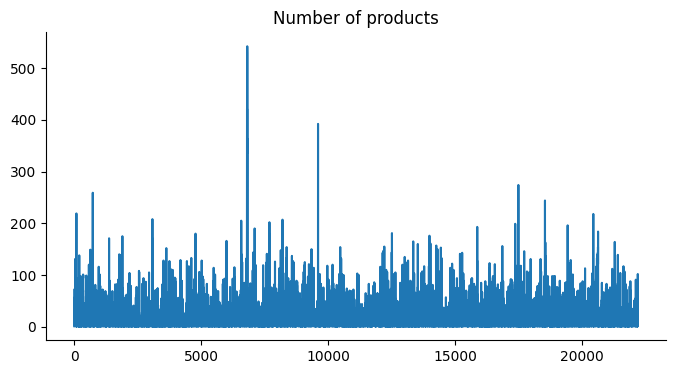

In [13]:
# @title Number of products

from matplotlib import pyplot as plt
nb_products_per_basket['Number of products'].plot(kind='line', figsize=(8, 4), title='Number of products')
plt.gca().spines[['top', 'right']].set_visible(False)

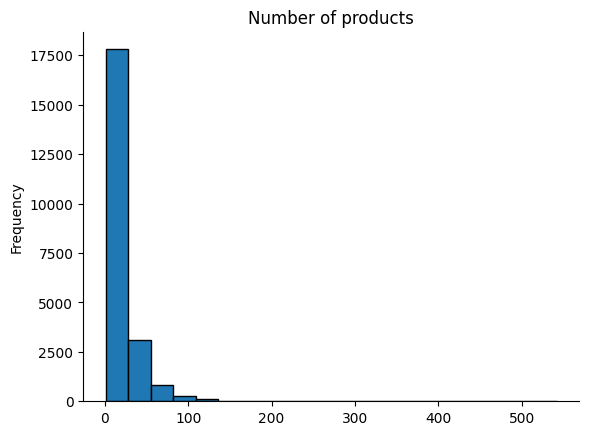

In [14]:
# @title Number of products

from matplotlib import pyplot as plt
nb_products_per_basket['Number of products'].plot(kind='hist', bins=20, title='Number of products')
plt.gca().spines[['top', 'right',]].set_visible(False)

Создадим в ваших данных о транзакциях признак `QuantityCanceled`. Этот признак будет указывать на количество отменённого впоследствии товара для каждой транзакции, на которую найдётся противоположная ей транзакция с возвратом. Для транзакций, для которых не было возвратов, признак будет равен 0. Для транзакций, для которых указано отрицательное количество товара, но в данных отсутствует контрагент, признак будет пустым.

Используем функцию `get_quantity_canceled()`, которая принимает на вход таблицу с транзакциями и возвращает объект `Series` — столбец, в котором указано количество отменённого впоследствии товара для каждой транзакции. Если транзакция не имеет контрагента, этот признак помечается как `NaN`.

Отметим, что эта функция не учитывает сложный случай, когда количество отменённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).

In [15]:
def get_quantity_canceled(data):
    """Функция для создания признака количества отменённых заказов.
    Функция принимает на вход таблицу и возвращает столбец, в котором указано количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция с отрицательным количеством товара не имеет контрагента, данный признак помечается как NaN.

    Args:
        data (DataFrame): таблица с транзакциями

    Returns:
        Series: столбец с количеством отменённого товара
    """
    # Инициализируем нулями Series той же длины, что и столбцы таблицы.
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) &
                       (data['InvoiceDate'] < col['InvoiceDate']) &
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента — ничего не делаем
        if (df_test.shape[0] == 0):
            # Помечаем столбец как пропуск
            quantity_canceled.loc[index] = np.nan
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отменённого товара в столбец QuantityCanceled
        elif (df_test.shape[0] == 1):
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']
        # Транзакция-возврат имеет несколько контрагентов
        # Задаём количество отменённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара больше количества товаров в транзакции-возврате.
        elif (df_test.shape[0] > 1):
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']:
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break
    return quantity_canceled

df_online_shop['QuantityCanceled'] = get_quantity_canceled(df_online_shop)

In [16]:
df_online_shop.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0


Узнаем, сколько транзакций в данных не имеют контрагентов, и, если их количество невелико, удалим их из данных.

Удалим транзакции с отрицательным количеством товара — они нам больше не нужны.



In [17]:
df_online_shop = df_online_shop[df_online_shop['Quantity'] > 0]

#### 2.1.4. Специализированные транзакции

Следующая задача — обработать специальные виды транзакций, которые обозначаются латинскими буквами.

В данных присутствует шесть специальных видов транзакций. С помощью регулярных выражений найдём такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры).

Чтобы понять, что означают эти коды, можно заглянуть в столбец с описанием (Description), например POST означает почтовые расходы, C2 — расходы на транспортировку, BANK CHARGES — банковские расходы.

Специальные операции не характеризуют покупательскую способность клиентов, так как не относятся напрямую к их покупкам, поэтому такие записи нам не нужны. Удалим все специальные транзакции из таблицы.

In [18]:
mask = df_online_shop['StockCode'].str.contains(r'^[a-zA-Z]+', regex=True)
display(df_online_shop[mask]['StockCode'].value_counts())
df_test = df_online_shop[~mask]
print(f'Данные до удаления: {df_online_shop.shape}')
print(f'Данные после удаления: {df_test.shape}')
df_online_shop = df_test.copy()

,count
StockCode,
POST,1099
M,285
C2,133
DOT,16
BANK CHARGES,12
PADS,4


Данные до удаления: (392732, 9)
Данные после удаления: (391183, 9)


In [19]:
df_online_shop.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0


#### 2.1.5. Транзакции с товарами без стоимости

При просмотре описательных статистик можно заметить, что на некоторые товары установлена цена в 0 фунтов стерлингов. Таких транзакций оказывается менее 1 % — можно удалить их.

In [20]:
df_online_shop = df_online_shop[~(df_online_shop['UnitPrice'] == 0)]

#### 2.1.6. Общая стоимость товаров в транзакции

Добавbv в ваш датасет общую цену заказа (TotalPrice). Она рассчитывается как:

 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Этот признак впоследствии поможет вам рассчитать покупательскую способность каждого из клиентов.

In [21]:
df_online_shop['TotalPrice'] = df_online_shop['UnitPrice'] * (df_online_shop['Quantity'] - df_online_shop['QuantityCanceled'])

In [22]:
df_online_shop.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34


### 2.2. Разведывательный анализ

После предобработки исходных данных произведём разведывательный анализ и исследуем транзакции, ответив на следующие вопросы:

* Клиенты из каких стран покупают больше и чаще?
* Какие страны приносят наибольшую сезонную выручку?
* Присутствует ли в продажах сезонность (когда покупают чаще)?
* Сгруппируем данные по датам и часам совершения транзакции и найдём количество заказов на каждый день-час. Затем найдём среднее количество ежедневно поступающих заказов в каждый из часов.
* Каково распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции)?




In [23]:
# Группировка по странам: количество заказов и уникальных клиентов
countries_grouped = df_online_shop.groupby('Country', as_index=False).agg(
    TotalPurchases=('InvoiceNo', 'count'),  # Общее количество покупок (заказов)
    UniqueCustomers=('CustomerID', 'nunique'),  # Количество уникальных клиентов
    TotalRevenue=('TotalPrice', 'sum')  # Общая сумма покупок
).sort_values(by='TotalPurchases', ascending=False)

In [24]:
countries_grouped.head(6)

,Country,TotalPurchases,UniqueCustomers,TotalRevenue
35,United Kingdom,348872,3916,6797691.44
14,Germany,8643,94,201520.71
13,France,8019,87,181529.63
10,EIRE,7126,3,247074.57
30,Spain,2417,30,51764.90
23,Netherlands,2322,9,283443.54


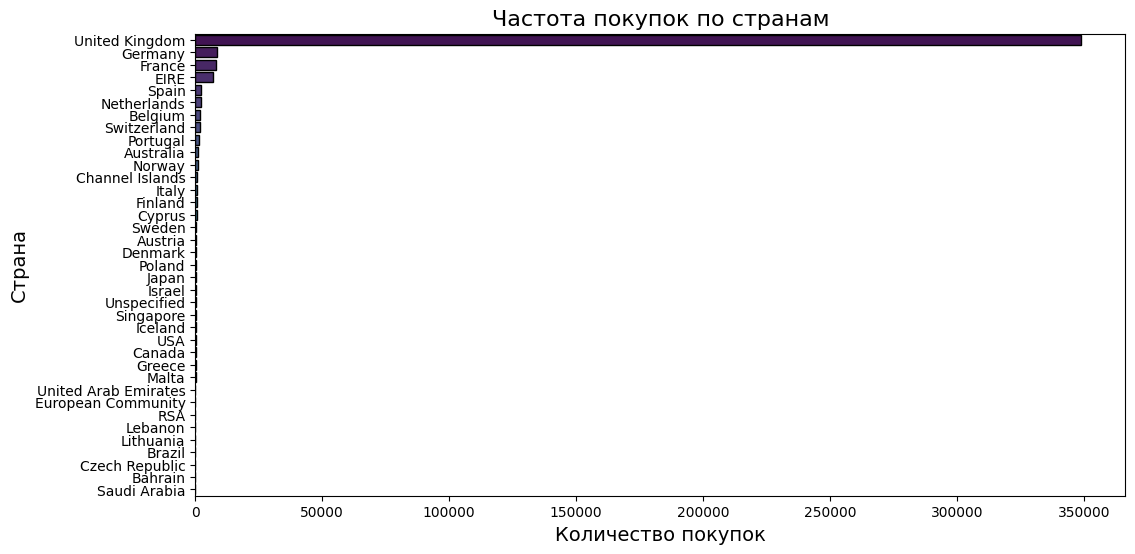

In [25]:
# Создание графика для отображения частоты покупок
plt.figure(figsize=(12, 6))

# Столбчатая диаграмма для общего количества покупок
sns.barplot(x='TotalPurchases', y='Country', data=countries_grouped, palette='viridis')

# Добавление заголовка и меток осей
plt.title('Частота покупок по странам', fontsize=16)
plt.xlabel('Количество покупок', fontsize=14)
plt.ylabel('Страна', fontsize=14)

# Отображение графика
plt.show()

Указанные данные и график свидетельствут о том, что подавляющее большинство покупок совершаются клиентами из **Великобритании**, далее примерно наравне идут Германия, Франция и Ирландия, покупательная активность из остальных стран гораздо ниже.

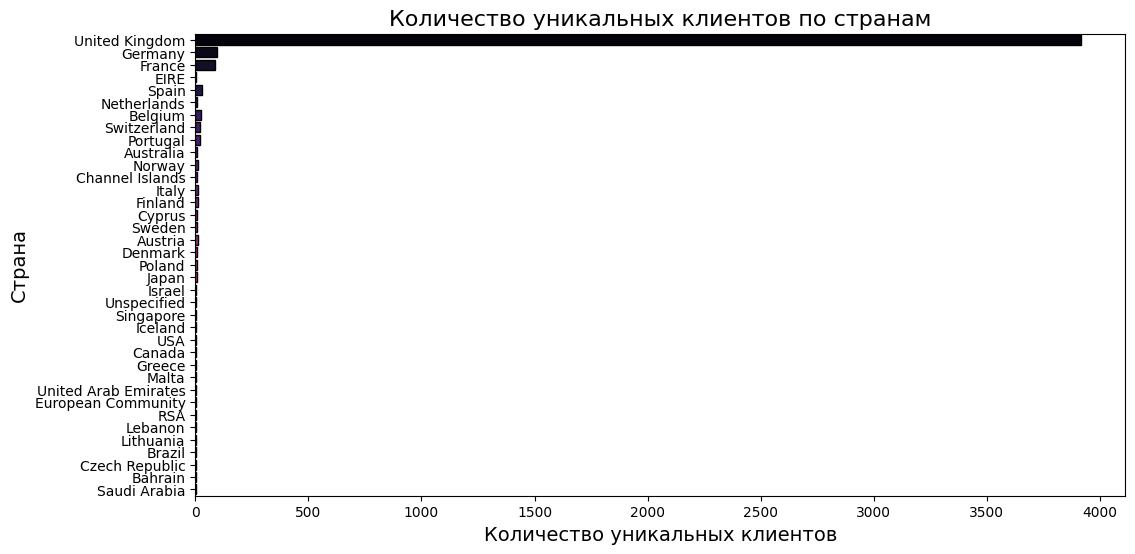

In [26]:
# Создание графика для отображения количества уникальных клиентов
plt.figure(figsize=(12, 6))
sns.barplot(x='UniqueCustomers', y='Country', data=countries_grouped, palette='magma')

# Добавление заголовка и меток осей
plt.title('Количество уникальных клиентов по странам', fontsize=16)
plt.xlabel('Количество уникальных клиентов', fontsize=14)
plt.ylabel('Страна', fontsize=14)

# Отображение графика
plt.show()

Подавляющее число уникальных клиентов также приходится на **Великобританию**, Франция и Германия с большим отставанием занимают 2 и 3 место.

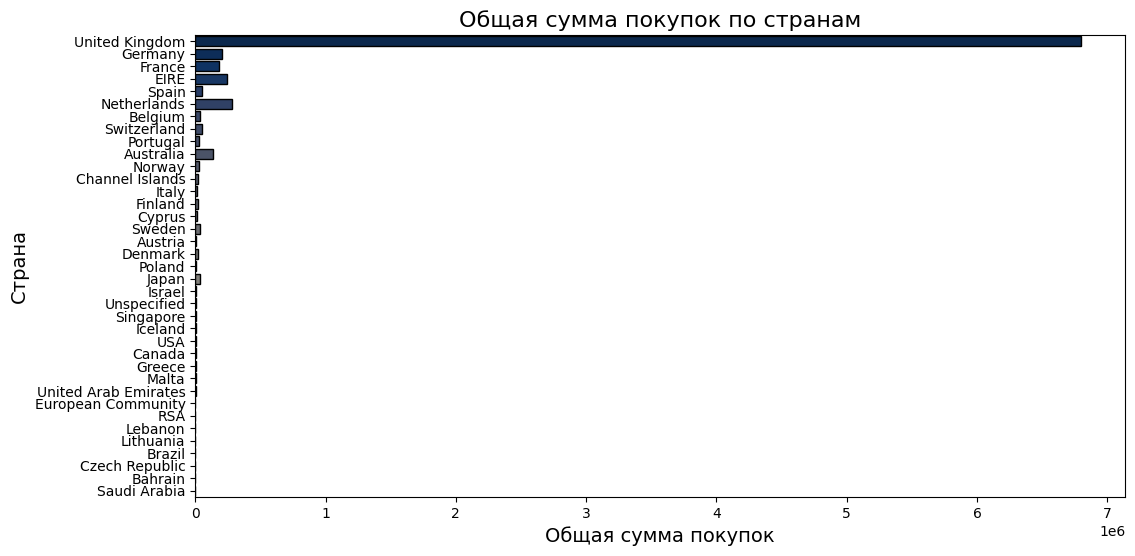

In [27]:

# Создание графика для отображения общей суммы покупок
plt.figure(figsize=(12, 6))
sns.barplot(x='TotalRevenue', y='Country', data=countries_grouped, palette='cividis')

# Добавление заголовка и меток осей
plt.title('Общая сумма покупок по странам', fontsize=16)
plt.xlabel('Общая сумма покупок', fontsize=14)
plt.ylabel('Страна', fontsize=14)

# Отображение графика
plt.show()


Динамика по общей сумме покупок такая же: **Великобритания** главенствует, далее выделяются Нидерланды, Ирландия, Франция, Германия, а также Австралия.

In [28]:
df_online_shop['Quarter'] = df_online_shop.InvoiceDate.dt.quarter


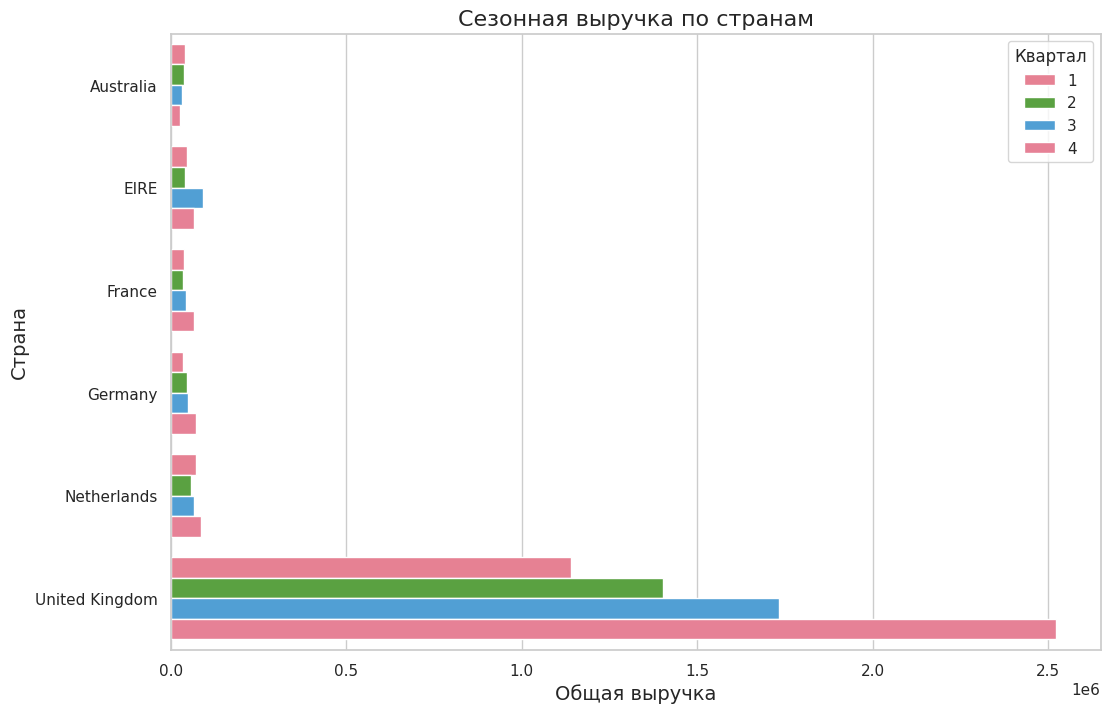

In [29]:

season_grouped = df_online_shop.groupby(['Country', 'Quarter'])['TotalPrice'].sum().reset_index()

# Сортировка по общей выручке для каждой страны
total_revenue_by_country = season_grouped.groupby('Country')['TotalPrice'].sum().reset_index()
total_revenue_by_country = total_revenue_by_country.sort_values(by='TotalPrice', ascending=False)

# Выбор топ-10 стран для визуализации
top_countries = total_revenue_by_country.head(6)['Country']
season_grouped_top = season_grouped[season_grouped['Country'].isin(top_countries)]

# Настройка стиля графика
sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(12, 8))
sns.barplot(x='TotalPrice', y='Country', hue='Quarter', data=season_grouped_top, palette='husl')

# Добавление заголовка и меток осей
plt.title('Сезонная выручка по странам', fontsize=16)
plt.xlabel('Общая выручка', fontsize=14)
plt.ylabel('Страна', fontsize=14)

# Отображение легенды
plt.legend(title='Квартал')

# Отображение графика
plt.show()


Сезонная выручка свидетельствует, что большие доходы магазин получает **в 4 декаде**. Это, скорее всего, обусловлено рождественскими тратами клиентов магазина.

In [30]:
df_online_shop.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,Quarter
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30,4
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,4


In [31]:
df_online_shop['Hour'] = df_online_shop['InvoiceDate'].dt.hour
df_online_shop['Date'] = df_online_shop['InvoiceDate'].dt.date

In [32]:
df_online_shop.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,Quarter,Hour,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30,4,8,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,4,8,2010-12-01


In [33]:
gr_dt_hour = df_online_shop.groupby(['Date', 'Hour'], as_index=False)['Quantity'].mean()

In [34]:
gr_dt_hour

,Date,Hour,Quantity
0,2010-12-01,8,13.311111
1,2010-12-01,9,21.885906
2,2010-12-01,10,25.666667
3,2010-12-01,11,6.472934
4,2010-12-01,12,10.070388
...,...,...,...
2848,2011-12-09,8,26.223214
2849,2011-12-09,9,1416.051724
2850,2011-12-09,10,15.875000
2851,2011-12-09,11,9.763359


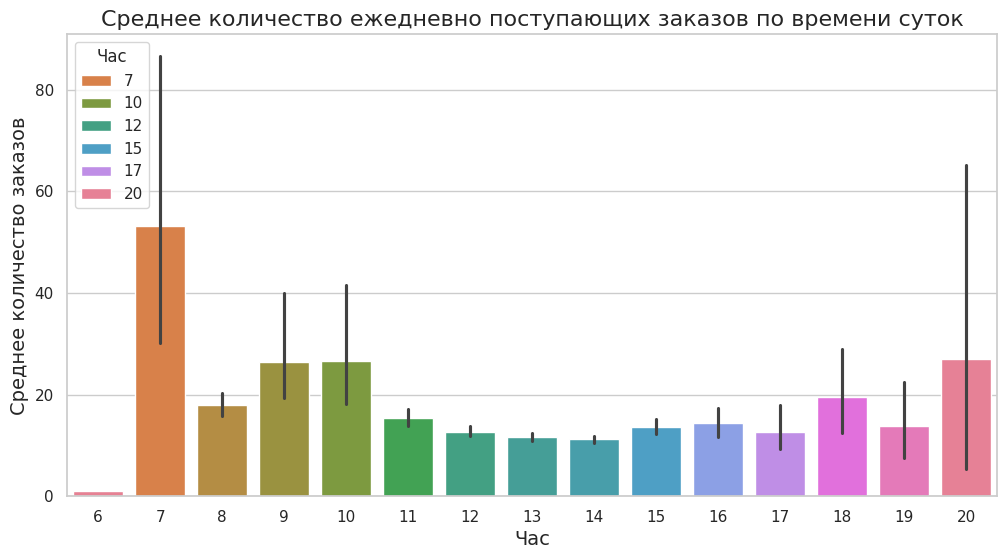

In [35]:
# Настройка стиля графика
sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(12, 6))
sns.barplot(x='Hour', y='Quantity', hue='Hour', data=gr_dt_hour, palette='husl')

# Добавление заголовка и меток осей
plt.title('Cреднее количество ежедневно поступающих заказов по времени суток', fontsize=16)
plt.xlabel('Час', fontsize=14)
plt.ylabel('Cреднее количество заказов', fontsize=14)

# Отображение легенды
plt.legend(title='Час')

# Отображение графика
plt.show()


Указанный график говорит о том, что наибольшим спросом магазин пользуется **в 7 часов утра**, далее лидируют 9, 10 и 20 часов.

### 2.3. Построение RFM-таблицы и поиск RFM-выбросов

Предстоит сформировать признаки, на основе которых будет производиться сегментация клиентов.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $t_0-max(t_{i1}, \ t_{i2}, \ ..., \ t_{iM})$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов).

In [36]:
recency_df = df_online_shop.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_df['Recency'] = (pd.to_datetime('2011-12-10') - recency_df['InvoiceDate']).dt.days
recency_df.drop('InvoiceDate', axis=1, inplace=True)
recency_df.head()

,CustomerID,Recency
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


In [37]:
frequency_df = df_online_shop.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_df.rename(columns={"InvoiceNo": "Frequency"}, inplace=True)
frequency_df.head()

,CustomerID,Frequency
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


In [38]:
monetary_df = df_online_shop.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary_df.rename(columns={"TotalPrice": "Monetary"}, inplace=True)
monetary_df.head()

,CustomerID,Monetary
0,12346,0.00
1,12347,4310.00
2,12348,1437.24
3,12349,1457.55
4,12350,294.40


После того как подготовили RFM-таблицу, визуализируем каждую из трёх компонент, например, в виде коробчатых диаграмм (boxplot).

In [39]:
rfm_table = recency_df.merge(frequency_df, on='CustomerID', how='inner')
rfm_table = rfm_table.merge(monetary_df, on='CustomerID', how='inner')
rfm_table.drop(columns='CustomerID', axis=1, inplace=True)
rfm_table.head(10)

,Recency,Frequency,Monetary
0,325,1,0.00
1,2,7,4310.00
2,75,4,1437.24
3,18,1,1457.55
4,310,1,294.40
5,36,7,1265.41
6,204,1,89.00
7,232,1,1079.40
8,214,1,459.40
9,22,3,2487.43


In [40]:
rfm_table.shape[0]

4334

In [41]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
#fig.write_html('plotly/boxplot_1.html')
fig.show()

Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


In [42]:
frequency_quantile_95 = np.percentile(rfm_table['Frequency'], 95)
monetary_quantile_95 = np.percentile(rfm_table['Monetary'], 95)

rfm_table_cleaned = rfm_table[~((rfm_table['Frequency'] > frequency_quantile_95) | (rfm_table['Monetary'] > monetary_quantile_95))]
print('Данные о {} клиентах остались в RFM-таблице'.format(rfm_table_cleaned.shape[0]))

Данные о 4044 клиентах остались в RFM-таблице


In [43]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
#fig.write_html('plotly/boxplot_1.html')
fig.show()

## 3. Моделирование и оценка качества моделей

Чтобы результаты кластеризации было удобнее интерпретировать, вы можете уменьшить размерность исходных признаков до двух компонент.

**Подсказка.** Чтобы методы понижения размерности работали стабильно, данные необходимо стандартизировать/нормализовать.

Произведем предобработку исходных данных. На основе RFM-признаков кластеризуем клиентов онлайн-магазина подарков.

Подберем оптимальное количество кластеров для выбранных методов с помощью коэффициента силуэта, перебирая возможные значения от 3 до 10 включительно (большее или меньшее количество кластеров будет нерелеватно для маркетинга).

Выберим алгоритм с наибольшим коэффициентом силуэта, сделаем предсказание меток кластеров.


In [44]:
# Создание пайплайна для стандартизации и PCA
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

X_reduced = pipeline.fit_transform(rfm_table_cleaned)

# 3. Кластеризация с использованием различных методов
cluster_algorithms = {
    'KMeans': KMeans(),
    'Agglomerative': AgglomerativeClustering(),
    'DBSCAN': DBSCAN()
}

best_score = -1
best_algorithm = None
best_labels = None

# Перебор количества кластеров от 3 до 10 для KMeans и Agglomerative
for algorithm_name, algorithm in cluster_algorithms.items():
    if algorithm_name in ['KMeans', 'Agglomerative']:
        for n_clusters in range(3, 11):
            if algorithm_name == 'KMeans':
                algorithm.set_params(n_clusters=n_clusters)
            elif algorithm_name == 'Agglomerative':
                algorithm.set_params(n_clusters=n_clusters)

            labels = algorithm.fit_predict(X_reduced)
            silhouette_avg = silhouette_score(X_reduced, labels)

            print(f'{algorithm_name} - Количество кластеров: {n_clusters}, Коэффициент силуэта: {silhouette_avg}')

            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_algorithm = algorithm_name
                best_labels = labels

    elif algorithm_name == 'DBSCAN':
        labels = algorithm.fit_predict(X_reduced)
        silhouette_avg = silhouette_score(X_reduced, labels)
        print(f'{algorithm_name} - Коэффициент силуэта: {silhouette_avg}')

        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_algorithm = algorithm_name
            best_labels = labels

print(f'\nЛучший алгоритм: {best_algorithm} с коэффициентом силуэта: {best_score}')

KMeans - Количество кластеров: 3, Коэффициент силуэта: 0.5241734291185538
KMeans - Количество кластеров: 4, Коэффициент силуэта: 0.49127617816799873
KMeans - Количество кластеров: 5, Коэффициент силуэта: 0.4530743454023724
KMeans - Количество кластеров: 6, Коэффициент силуэта: 0.4440605089543389
KMeans - Количество кластеров: 7, Коэффициент силуэта: 0.3977217566472836
KMeans - Количество кластеров: 8, Коэффициент силуэта: 0.4035377002770867
KMeans - Количество кластеров: 9, Коэффициент силуэта: 0.36201711819505394
KMeans - Количество кластеров: 10, Коэффициент силуэта: 0.38793841477167074
Agglomerative - Количество кластеров: 3, Коэффициент силуэта: 0.49675931818769936
Agglomerative - Количество кластеров: 4, Коэффициент силуэта: 0.42530997015765426
Agglomerative - Количество кластеров: 5, Коэффициент силуэта: 0.43906190346482427
Agglomerative - Количество кластеров: 6, Коэффициент силуэта: 0.421116017085549
Agglomerative - Количество кластеров: 7, Коэффициент силуэта: 0.41276311069064

### 3.2. Интерпретация результатов кластеризации

Перейдём к интерпретации полученных кластеров.

#### 3.2.1. Визуализация кластеров

Визуализируйте результаты в виде 3D-диаграммы с осями Recency, Frequency и Monetary. Проанализируйте полученную диаграмму и попробуйте понять, какие кластеры у вас получились.

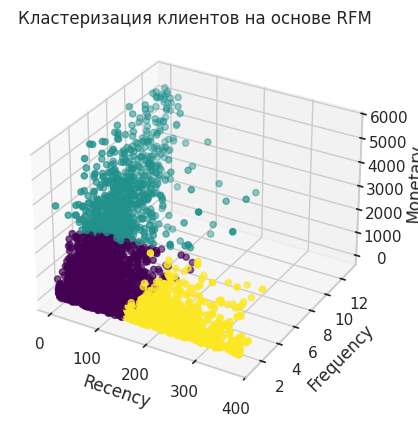

In [45]:
# Визуализация результатов в виде 3D-диаграммы
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_table_cleaned['Recency'], rfm_table_cleaned['Frequency'], rfm_table_cleaned['Monetary'], c=best_labels, cmap='viridis')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('Кластеризация клиентов на основе RFM')
plt.show()

#### 3.2.2. Построение профиля кластеров

Далее составим так называемый профиль кластеров. Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

Чтобы результаты было проще интерпретировать используем **Radar Chart** (полярная диаграмма, или диаграмма паутины). Это графическое представление значений нескольких эквивалентных категорий в форме паутины.

In [46]:
rfm_table_cleaned['KMeans_label'] = best_labels
rfm_table_cleaned

,Recency,Frequency,Monetary,KMeans_label
0,325,1,0.00,2
1,2,7,4310.00,1
2,75,4,1437.24,0
3,18,1,1457.55,0
4,310,1,294.40,2
...,...,...,...,...
4328,73,1,173.90,0
4329,277,1,180.60,2
4330,180,1,80.82,2
4331,7,2,176.60,0


In [47]:
rfm_table_cleaned['KMeans_label'].value_counts()

,count
KMeans_label,
0,2267
2,1001
1,776


In [48]:
rfm_table_cleaned_grouped = rfm_table_cleaned.groupby('KMeans_label').mean()
rfm_table_cleaned_grouped

,Recency,Frequency,Monetary
KMeans_label,,,
0,51.127481,2.329069,660.168677
1,31.943299,7.068299,2657.746997
2,253.283716,1.405594,386.598472


In [49]:
def plot_cluster_profile(grouped_data, n_clusters):
    """Функция для визуализации профиля кластеров в виде полярной диаграммы.

    Args:
        grouped_data (DataFrame): таблица, сгруппированная по номерам кластеров с агрегированными характеристиками объектов.
        n_clusters (int): количество кластеров
    """
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = MinMaxScaler()
    normalized_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)

    # Создаём список признаков
    features = normalized_data.columns
    # Создаём пустую фигуру
    fig = go.Figure()

    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r=normalized_data.iloc[i].values,  # радиусы
            theta=features.tolist(),  # название засечек
            fill='toself',  # заливка многоугольника цветом
            name=f'Cluster {i}',  # название — номер кластера
        ))

    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True,  # отображение легенды
        autosize=False,  # устанавливаем свои размеры графика
        width=600,  # ширина (в пикселях)
        height=600,  # высота (в пикселях)
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]  # диапазон для радиальной оси
            )
        ),
    )

    # Отображаем фигуру
    fig.show()

In [50]:
net_scatter = plot_cluster_profile(rfm_table_cleaned_grouped, 3)
net_scatter

По графику видно, что к наиболее **лояльным** и можно отнести клиентов из кластера **0**. У них наибольшая частота приобретений товара, а также они приносят наибольшую прибыль.

К **зоне риска** можно отнести клиентов из клвастера **1**, их показатели более скромны, но их еще нельзя отнести к клиентам, которые относятся к зоне потери.

Клиенты из кластера **2** относятся к **зоне потери**.